In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling1D
from nltk.tokenize import TreebankWordTokenizer, sent_tokenize
import re
from tqdm.auto import tqdm
import seaborn as sb
import pickle,os,random
from string import punctuation
from bpe_tokenizer import BPETokenizer
from sklearn.model_selection import train_test_split
from bert import BERT


print(tf.config.list_physical_devices('GPU')) # GPU detection check

# function for fixed initialization
def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(2)
    tf.random.set_seed(2)
    np.random.seed(2)
    random.seed(2)

# load pretrained BPETokenizer
if __name__ == "__main__":

    with open('tokenizer.pkl','rb') as f:
        bpe_tok = pickle.load(f)

2024-04-04 13:35:22.996344: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 13:35:22.996374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 13:35:22.997195: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 13:35:23.002288: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 13:35:23.715444: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-04 13:35:26.366564: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 13:35:26.394036: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 13:35:26.394232: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
def preprocess_text(x):
    """
    cleaning tweets -> 
    @user -> USER
    urls -> LINK
    keep only !,.:#? and add space 
    """
    x = str(x).replace('&amp;','and').replace('<br />','').replace('&quot;','')
    x = x.lower()
    x = re.sub(r'[^\x00-\x7F]+', "'",x)
    url_pattern = r'http\S+|www\S+'
    x = re.sub(url_pattern, 'LINK', x).split()
    for i,w in enumerate(x):
        if '@' in w:
            x[i] = 'USER'
    x = ' '.join(x)
    punct_to_keep = """!,.:#?"-;//%$'"""
    punct = ''.join([p for p in punctuation if p not in punct_to_keep])
    trans = str.maketrans(punct, ' ' * len(punct))
    x = x.translate(trans)
    x = ''.join(x)
    x = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])\s*\1+', r'\1', x)
    x = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])', r' \1 ', x)
    x = re.sub(r'\s+', ' ', x).strip().replace("'s "," 's ")
    return x


In [3]:
# function to split text in subwords and truncate

def split_truncate(sent,maxlen=300):
    text = sent.split()
    text = [bpe_tok._split_oov(w) for w in text]
    text = ' '.join(text)
    
    if maxlen is not None:
        maxlen -= 2
        text = text.split()[:maxlen]
        text = ' '.join(text)
    
    text = '<cls> ' + text + ' <sep>'
    return text


In [4]:
# prepare data for model training

def prepare_data(text,y,batch,maxlen=128):
    text = [preprocess_text(x) for x in text]
    text = [split_truncate(x,maxlen) for x in tqdm(text)]
    tokenized = [bpe_tok.tokenize(x) for x in text]
    tokenized = [bpe_tok.add_padding(x,maxlen) for x in tokenized]
    seq = np.asarray(tokenized)
    xtrain,xval,ytrain,yval = train_test_split(seq,y,train_size=0.8,random_state=0)
    train = tf.data.Dataset.from_tensor_slices((xtrain,ytrain))
    train = train.batch(batch_size=batch, drop_remainder=True)
    valid = tf.data.Dataset.from_tensor_slices((xval,yval))
    valid = valid.batch(batch_size=batch)
    steps = len(xtrain) // batch + 1
    return train,valid,steps

In [5]:
def build_model(d_model,n_heads,n_layers,units,pos_weights,vocab_size,maxlen,batch,
                pretrained=False,n_classes=None):
    
    reset_random_seeds()
    
    
    i = Input((maxlen,),batch_size=batch, dtype=tf.int32)
    bert_model = BERT(d_model=d_model, n_heads=n_heads, n_encoder_layer=n_layers,
                  units=units, pos_weights=encodings, vocab_size=vocab_size)
    out = bert_model(i)
    out = GlobalAveragePooling1D()(out)
    if n_classes is None:
        out = Dense(1,activation='sigmoid')(out)
    else:
        out = Dense(n_classes,activation='softmax')(out)

    model = tf.keras.Model(i,out)
    
    
    if pretrained:
        model.layers[1].load_weights('mlm_bert.h5')
    
    return model
    
def positional_encoding(emb_dim,maxlen):
    pos = np.zeros((maxlen, emb_dim), dtype=np.float32)
    for p in range(maxlen):
        for i in range(emb_dim):
            if i % 2 == 0:
                angle = p / 10000 ** (2 * i / emb_dim)
                pos[p, i] = np.sin(angle)
            else:
                angle = p / 10000 ** (2 * i / emb_dim)
                pos[p, i] = np.cos(angle)
                
    return pos

<Axes: >

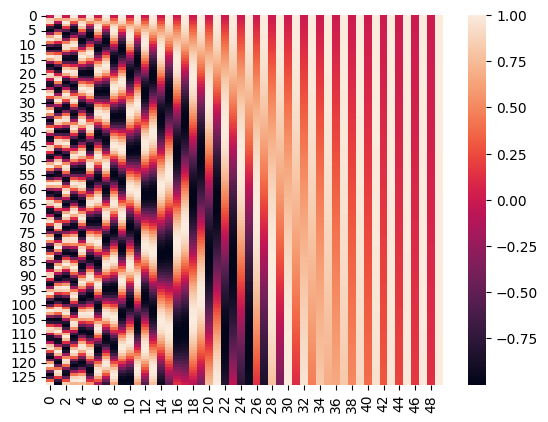

In [6]:
# parameters

epochs = 2
batch = 32
d_model = 128
n_heads = 8
units = d_model * 2
vocab_size = len(bpe_tok.i2w)
n_layers = 4
maxlen = 128
encodings = positional_encoding(d_model,maxlen)

sb.heatmap(encodings[:,:50])

In [7]:
# loading seen data (IMDB Dataset)
# only using 5000 samples as the dataset easy

df = pd.read_csv('/home/bibek/notebooks/IMDB Dataset.csv')

text = df.review.tolist()
try:
    y = df.sentiment.map({'positive':1,'negative':0}).values
except:
    y = df.target.values

train,valid,steps = prepare_data(text,y,batch)

  0%|          | 0/50000 [00:00<?, ?it/s]

2024-04-04 13:37:44.714518: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 13:37:44.714778: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-04 13:37:44.714930: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
# build the 2 models

pretrained_model = build_model(d_model,n_heads,n_layers,units,encodings,vocab_size,
                               maxlen,batch,pretrained=True)
model = build_model(d_model,n_heads,n_layers,units,encodings,vocab_size,maxlen,batch)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(32, 128)]               0         
                                                                 
 bert_1 (BERT)               (32, 128, 128)            3153024   
                                                                 
 global_average_pooling1d_1  (32, 128)                 0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_1 (Dense)             (32, 1)                   129       
                                                                 
Total params: 3153153 (12.03 MB)
Trainable params: 3153153 (12.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<Axes: >

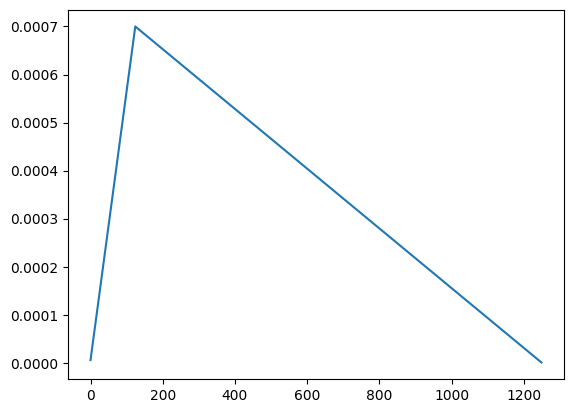

In [9]:
# lr scheduling

class BERTLearningRateScheduler:
    
    def __init__(self,total_steps,init_lr=1e-3):
        self.total = total_steps
        self.warmup = total_steps // 10
        self.decay = total_steps - self.warmup
        self.init_lr = init_lr
        
    def __call__(self,step):
        if step <= self.warmup:
            lr = self.init_lr * (step / self.warmup)
        else:
            lr = self.init_lr * max(0,(self.total - step) / (max(1,self.decay)))
            
        return lr


custom_lr_sch = BERTLearningRateScheduler(steps,init_lr=7e-4)
sb.lineplot([custom_lr_sch(s) for s in range(1,steps)])

In [11]:
# model training function

def train_model(epochs,model,optimizer,loss_fn,custom_lr_sch,save_path):
    
    @tf.function
    def train_step(x,y,model,optimizer,loss_fn):
        with tf.GradientTape() as tape:
            pred = model(x, training=True)
            loss = loss_fn(y, pred)
        weights = model.trainable_weights
        grads = tape.gradient(loss,weights)
        optimizer.apply_gradients(zip(grads,weights))
        return loss

    @tf.function
    def test_step(x,y,model,loss_fn):
        pred = model(x, training=False)
        loss = loss_fn(y, pred)
        return loss
    
    losses = {"train":[],'valid':[]}
    
    for e in range(1,epochs+1):
        print(f'epochs : {e}/{epochs}')
        loss = 0
        for i,(x,y) in enumerate(tqdm(train)):
            lr = custom_lr_sch(i+1)
            optimizer.learning_rate.assign(lr)
            loss += train_step(x,y,model,optimizer,loss_fn)

        loss = round(loss.numpy()/i, 4)

        print('train loss :',loss)

        losses['train'].append(loss)

        loss = 0
        for i,(x,y) in enumerate(valid):
            loss += test_step(x,y,model,loss_fn)

        loss = round(loss.numpy()/i, 4)
        print('val loss :',loss)

        if e == 1:
            model.save_weights(save_path)
            print('best weights saved')

        elif min(losses['valid']) > loss:
            model.save_weights(save_path)
            print('best weights saved')

        losses['valid'].append(loss)
        print()

In [12]:
# train  model and load best saved weights

opt = tf.keras.optimizers.AdamW(weight_decay=0.001)
loss_fn = tf.keras.losses.BinaryCrossentropy()

train_model(2,model,opt,loss_fn,custom_lr_sch,'model.h5')

model.load_weights('model.h5')

epochs : 1/2


  0%|          | 0/1250 [00:00<?, ?it/s]

2024-04-04 13:38:30.456702: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-04 13:38:30.854825: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-04 13:38:31.889441: I external/local_xla/xla/service/service.cc:168] XLA service 0x77aebf38eb50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-04 13:38:31.889465: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-04-04 13:38:31.893746: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712218111.979070   27331 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


train loss : 0.4504
val loss : 0.3653
best weights saved

epochs : 2/2


  0%|          | 0/1250 [00:00<?, ?it/s]

train loss : 0.31
val loss : 0.3671



In [13]:
# train pretrained model and load best saved weights

opt = tf.keras.optimizers.AdamW(weight_decay=0.001)
loss_fn = tf.keras.losses.BinaryCrossentropy()

train_model(2,pretrained_model,opt,loss_fn,custom_lr_sch,'pretrained_model.h5')
pretrained_model.load_weights('pretrained_model.h5')

epochs : 1/2


  0%|          | 0/1250 [00:00<?, ?it/s]

train loss : 0.4054
val loss : 0.3469
best weights saved

epochs : 2/2


  0%|          | 0/1250 [00:00<?, ?it/s]

train loss : 0.2834
val loss : 0.3526



In [14]:
def predict(data,model):
    preds = []
    out = []
    for b,(x,y) in enumerate(data):
        pred = model(x, training=False).numpy()
        pred = np.round(pred[:,0])
        preds.extend(pred)
        out.extend(y.numpy())
        
    return preds,out     

In [15]:
# get predictions

pred1,yval = predict(valid,model)
pred2,yval = predict(valid,pretrained_model)

In [16]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_curve, roc_auc_score

In [17]:
# model classification report

print(classification_report(yval,pred1))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      5035
           1       0.84      0.83      0.84      4965

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [18]:
# pretrained model classification report

print(classification_report(yval,pred2))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      5035
           1       0.86      0.84      0.85      4965

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [19]:
# model and pretrained model F1 and ROC/AUC score

fpr1,tpr1,_ = roc_curve(yval,pred1,pos_label=1)
fpr2,tpr2,_ = roc_curve(yval,pred2,pos_label=1)

print('Non-Pretrained Model')
print('ROC AUC score :',roc_auc_score(yval,pred1))
print('F1 scores :',f1_score(yval,pred1))
print()
print('Pretrained Model')
print('ROC AUC score :',roc_auc_score(yval,pred2))
print('F1 scores :',f1_score(yval,pred2))

Non-Pretrained Model
ROC AUC score : 0.8373458299456673
F1 scores : 0.8351581508515814

Pretrained Model
ROC AUC score : 0.8494023207137151
F1 scores : 0.8464442403836343


[]

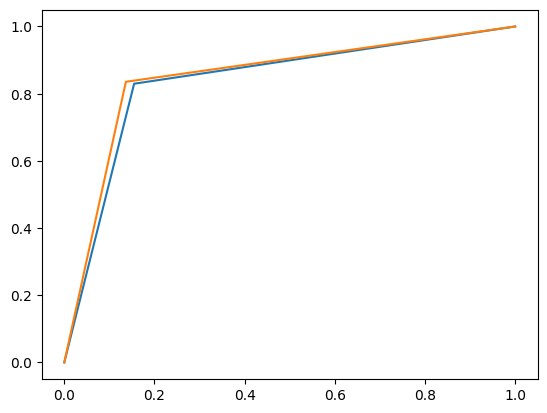

In [20]:
# ROC curve
plt.plot(fpr1,tpr1)
plt.plot(fpr2,tpr2)
plt.plot()

<Axes: >

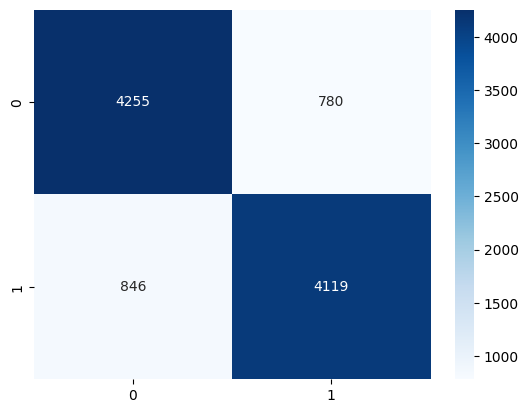

In [21]:
sb.heatmap(confusion_matrix(yval,pred1),cmap='Blues',annot=True,fmt='d')

<Axes: >

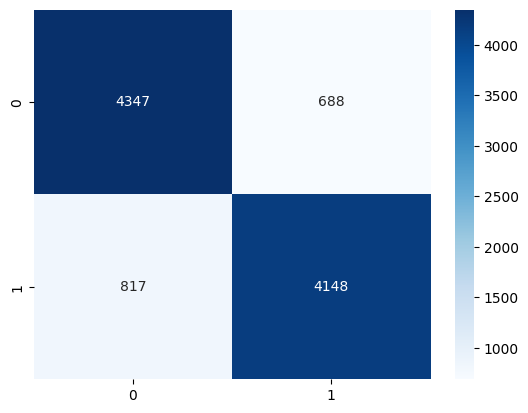

In [22]:
sb.heatmap(confusion_matrix(yval,pred2),cmap='Blues',annot=True,fmt='d')

In [23]:
# unseen data (Disaster Tweets)

batch = 8

df = pd.read_csv('/home/bibek/notebooks/train.csv')

text = df.text.tolist()
try:
    y = df.sentiment.map({'positive':1,'negative':0}).values
except:
    y = df.target.values

train,valid,steps = prepare_data(text,y,batch)

  0%|          | 0/7613 [00:00<?, ?it/s]

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(8, 128)]                0         
                                                                 
 bert_3 (BERT)               (8, 128, 128)             3153024   
                                                                 
 global_average_pooling1d_3  (8, 128)                  0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_3 (Dense)             (8, 1)                    129       
                                                                 
Total params: 3153153 (12.03 MB)
Trainable params: 3153153 (12.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


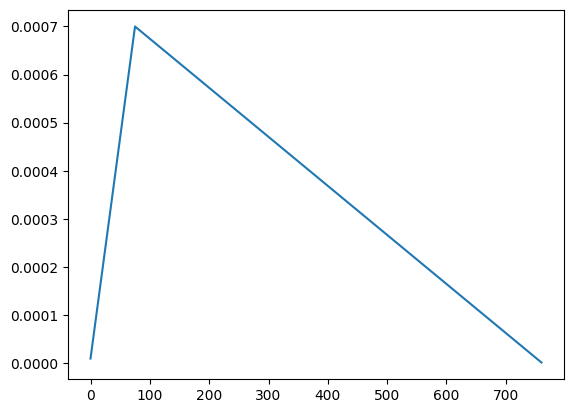

In [24]:


pretrained_model = build_model(d_model,n_heads,n_layers,units,encodings,vocab_size,
                               maxlen,batch,pretrained=True)
model = build_model(d_model,n_heads,n_layers,units,encodings,vocab_size,maxlen,batch)

custom_lr_sch = BERTLearningRateScheduler(steps,init_lr=7e-4)
sb.lineplot([custom_lr_sch(s) for s in range(1,steps)])

model.summary()

In [25]:
# Training model with same params

In [26]:
opt = tf.keras.optimizers.AdamW(weight_decay=0.001)
loss_fn = tf.keras.losses.BinaryCrossentropy()

train_model(2,model,opt,loss_fn,custom_lr_sch,'model.h5')

model.load_weights('model.h5')

epochs : 1/2


  0%|          | 0/761 [00:00<?, ?it/s]

train loss : 0.589
val loss : 0.5172
best weights saved

epochs : 2/2


  0%|          | 0/761 [00:00<?, ?it/s]

train loss : 0.4348
val loss : 0.4976
best weights saved



In [27]:
opt = tf.keras.optimizers.AdamW(weight_decay=0.001)
loss_fn = tf.keras.losses.BinaryCrossentropy()

train_model(2,pretrained_model,opt,loss_fn,custom_lr_sch,'pretrained_model.h5')

pretrained_model.load_weights('pretrained_model.h5')

epochs : 1/2


  0%|          | 0/761 [00:00<?, ?it/s]

train loss : 0.5321
val loss : 0.4663
best weights saved

epochs : 2/2


  0%|          | 0/761 [00:00<?, ?it/s]

train loss : 0.3657
val loss : 0.4855



In [28]:
pred1,yval = predict(valid,model)
pred2,yval = predict(valid,pretrained_model)

In [29]:
print(classification_report(yval,pred1))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       886
           1       0.73      0.75      0.74       637

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



In [30]:
print(classification_report(yval,pred2))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       886
           1       0.74      0.77      0.76       637

    accuracy                           0.79      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.79      0.79      0.79      1523



In [31]:
fpr1,tpr1,_ = roc_curve(yval,pred1,pos_label=1)
fpr2,tpr2,_ = roc_curve(yval,pred2,pos_label=1)

print('ROC AUC score :',roc_auc_score(yval,pred1))
print('F1 scores :',f1_score(yval,pred1))
print()
print('ROC AUC score :',roc_auc_score(yval,pred2))
print('F1 scores :',f1_score(yval,pred2))

ROC AUC score : 0.7736160968989089
F1 scores : 0.7382239382239383

ROC AUC score : 0.7883348512177922
F1 scores : 0.7553846153846154


[]

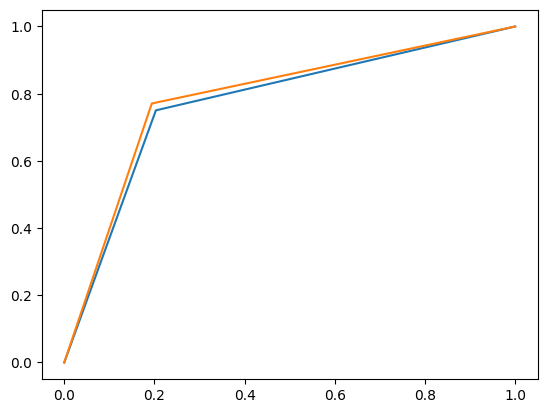

In [32]:
plt.plot(fpr1,tpr1)
plt.plot(fpr2,tpr2)
plt.plot()

In [33]:
df = pd.read_csv('df_file.csv')
df

,Text,Label
0,Budget to set scene for election\n \n Gordon B...,0
1,Army chiefs in regiments decision\n \n Militar...,0
2,Howard denies split over ID cards\n \n Michael...,0
3,Observers to monitor UK election\n \n Minister...,0
4,Kilroy names election seat target\n \n Ex-chat...,0
...,...,...
2220,India opens skies to competition\n \n India wi...,4
2221,Yukos bankruptcy 'not US matter'\n \n Russian ...,4
2222,Survey confirms property slowdown\n \n Governm...,4
2223,High fuel prices hit BA's profits\n \n British...,4


In [70]:
print(df.Text.tolist()[:5])

['Budget to set scene for election\n \n Gordon Brown will seek to put the economy at the centre of Labour\'s bid for a third term in power when he delivers his ninth Budget at 1230 GMT. He is expected to stress the importance of continued economic stability, with low unemployment and interest rates. The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from Â£60,000. But the Conservatives and Lib Dems insist voters face higher taxes and more means-testing under Labour.\n \n Treasury officials have said there will not be a pre-election giveaway, but Mr Brown is thought to have about Â£2bn to spare.\n \n - Increase in the stamp duty threshold from Â£60,000 \n  - A freeze on petrol duty \n  - An extension of tax credit scheme for poorer families \n  - Possible help for pensioners The stamp duty threshold rise is intended to help first time buyers - a likely theme of all three of the main parties\' general election manifestos. Ten years ago, buyers had a much 

In [35]:
df['Label'].value_counts()

Label
1    511
4    510
0    417
2    401
3    386
Name: count, dtype: int64

In [36]:
batch = 8

text = df['Text'].apply(lambda x: str(x)).tolist()
text = ['. '.join(t.split('\n')) for t in text]
y = df['Label'].values

train,valid,steps = prepare_data(text,y,batch)

  0%|          | 0/2225 [00:00<?, ?it/s]

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(8, 128)]                0         
                                                                 
 bert_5 (BERT)               (8, 128, 128)             3153024   
                                                                 
 global_average_pooling1d_5  (8, 128)                  0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_5 (Dense)             (8, 5)                    645       
                                                                 
Total params: 3153669 (12.03 MB)
Trainable params: 3153669 (12.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


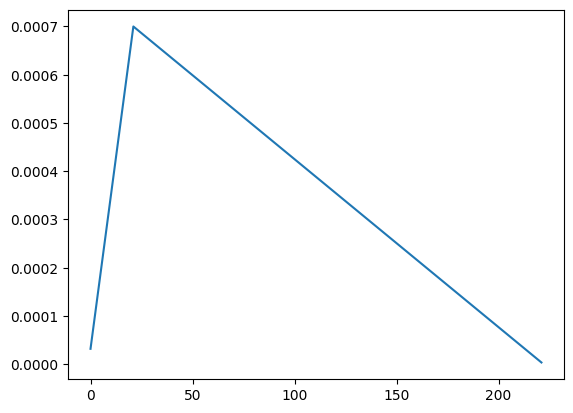

In [37]:
pretrained_model = build_model(d_model,n_heads,n_layers,units,encodings,vocab_size,
                               maxlen,batch,pretrained=True,n_classes=5)
model = build_model(d_model,n_heads,n_layers,units,encodings,vocab_size,maxlen,batch,n_classes=5)

custom_lr_sch = BERTLearningRateScheduler(steps,init_lr=7e-4)
sb.lineplot([custom_lr_sch(s) for s in range(1,steps)])

model.summary()

In [38]:
# train  model and load best saved weights

opt = tf.keras.optimizers.AdamW(weight_decay=0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

train_model(2,model,opt,loss_fn,custom_lr_sch,'model.h5')

model.load_weights('model.h5')

epochs : 1/2


  0%|          | 0/222 [00:00<?, ?it/s]

train loss : 1.4577
val loss : 0.8197
best weights saved

epochs : 2/2


  0%|          | 0/222 [00:00<?, ?it/s]

train loss : 0.5042
val loss : 0.235
best weights saved



In [39]:
# train pretrained model and load best saved weights

opt = tf.keras.optimizers.AdamW(weight_decay=0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

train_model(2,pretrained_model,opt,loss_fn,custom_lr_sch,'pretrained_model.h5')
pretrained_model.load_weights('pretrained_model.h5')

epochs : 1/2


  0%|          | 0/222 [00:00<?, ?it/s]

train loss : 0.6687
val loss : 0.1823
best weights saved

epochs : 2/2


  0%|          | 0/222 [00:00<?, ?it/s]

train loss : 0.1092
val loss : 0.1297
best weights saved



In [45]:
def predict(data,model):
    preds = []
    out = []
    for b,(x,y) in enumerate(data):
        pred = model(x, training=False).numpy()
        pred = np.argmax(pred,axis=-1)
        preds.extend(pred)
        out.extend(y.numpy())
        
    return preds,out

In [46]:
pred1,yval = predict(valid,model)
pred2,_ = predict(valid,pretrained_model)


In [47]:
print(classification_report(yval,pred1))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95        85
           1       0.97      0.99      0.98       110
           2       0.92      0.91      0.92        78
           3       0.87      0.87      0.87        79
           4       0.92      0.88      0.90        93

    accuracy                           0.93       445
   macro avg       0.92      0.92      0.92       445
weighted avg       0.93      0.93      0.93       445



In [48]:
print(classification_report(yval,pred2))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        85
           1       0.97      0.97      0.97       110
           2       0.96      0.99      0.97        78
           3       0.94      0.97      0.96        79
           4       0.96      0.92      0.94        93

    accuracy                           0.96       445
   macro avg       0.96      0.96      0.96       445
weighted avg       0.96      0.96      0.96       445



In [53]:
f1_score(yval,pred1,average='weighted')

0.9277670000414061

In [54]:
f1_score(yval,pred2,average='weighted')

0.9594443839661916

<Axes: >

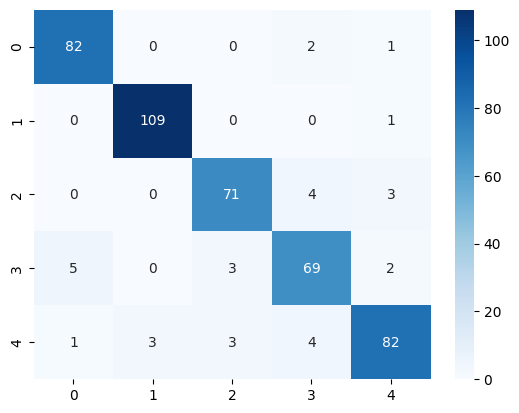

In [67]:
sb.heatmap(confusion_matrix(yval,pred1),cmap='Blues',annot=True,fmt='d')

<Axes: >

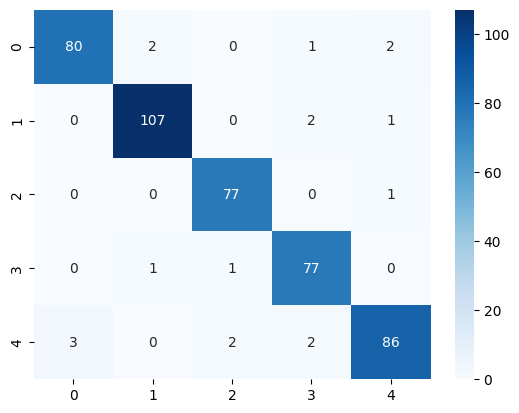

In [68]:
sb.heatmap(confusion_matrix(yval,pred2),cmap='Blues',annot=True,fmt='d')